## Random Forest Regression

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib


### Load Dataset

In [7]:

df = pd.read_csv('StudentsPerformance.csv')

In [8]:
# Create target and features
X = df.drop(columns=['math score'])
y = df['math score']

In [9]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()



In [10]:
# Preprocessing pipelines
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])



In [11]:
# Create the base model pipeline
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])



### Train-test split

In [12]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Hyperparameter tuning

In [13]:

param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt']
}

search = RandomizedSearchCV(base_model, param_distributions=param_grid, cv=5, n_iter=20, n_jobs=-1, random_state=42)
search.fit(X_train, y_train)



c:\Users\kirusanth\anaconda3\envs\ml-env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kirusanth\anaconda3\envs\ml-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kirusanth\anaconda3\envs\ml-env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kirusanth\anaconda3\envs\ml-env\Lib\site-packages\skl

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse_output=False),
                                                                               ['gender',
                                                                                'race/ethnicity',
                                                                                'parental '
                                                                                'level '
                                                                                'of '
                                                                                'education',
                                                                                'lunch',
                                                                                'test '
                                                                                'preparation '
                                                                                'course']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['reading '
                                                                                'score',
                                                                                'writing '
                                                                                'score'])])),
                                             ('regressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'regressor__max_depth': [None, 10, 20,
                                                                 30],
                                        'regressor__max_features': ['auto',
                                                                    'sqrt'],
                                        'regressor__min_samples_leaf': [1, 2,
                                                                        4],
                                        'regressor__min_samples_split': [2, 5,
                                                                         10],
                                        'regressor__n_estimators': [100, 200,
                                                                    300]},
                   random_state=42)

### Best model

In [14]:

model = search.best_estimator_
print("Best Parameters:", search.best_params_)



Best Parameters: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 30}


### Predict and evaluate

In [15]:

y_pred = model.predict(X_test)
print("R^2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))



R^2 Score: 0.8104983433054803
MAE: 5.196027380952382
MSE: 46.11302993739371


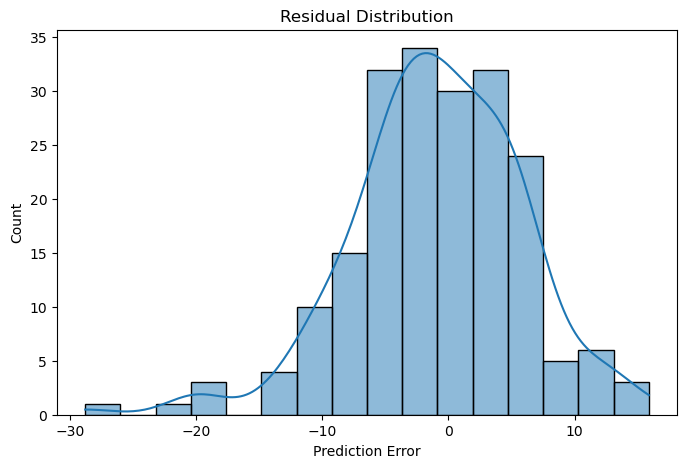

In [16]:
# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Prediction Error')
plt.show()



### Actual vs Predicted Plot

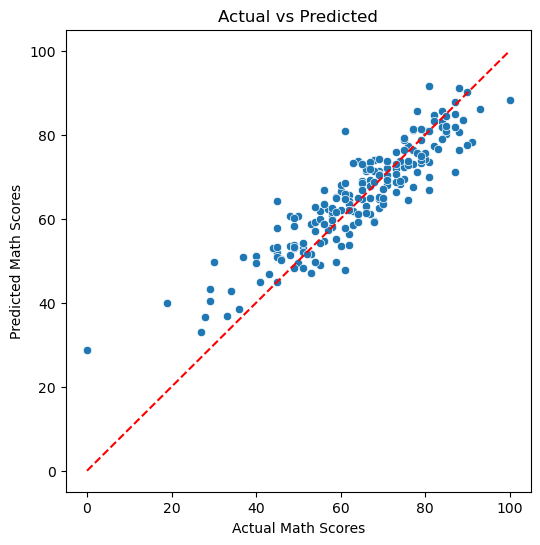

In [17]:

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Actual Math Scores')
plt.ylabel('Predicted Math Scores')
plt.title('Actual vs Predicted')
plt.show()



### Cross-validation

In [18]:
scores = cross_val_score(model, X, y, scoring='r2', cv=10)
print("Cross-Validated R^2:", np.mean(scores))

Cross-Validated R^2: 0.825812629328208


### Export model

In [19]:
joblib.dump(model, 'models/random_forest_model.pkl')

['models/random_forest_model.pkl']

### Feature Importances

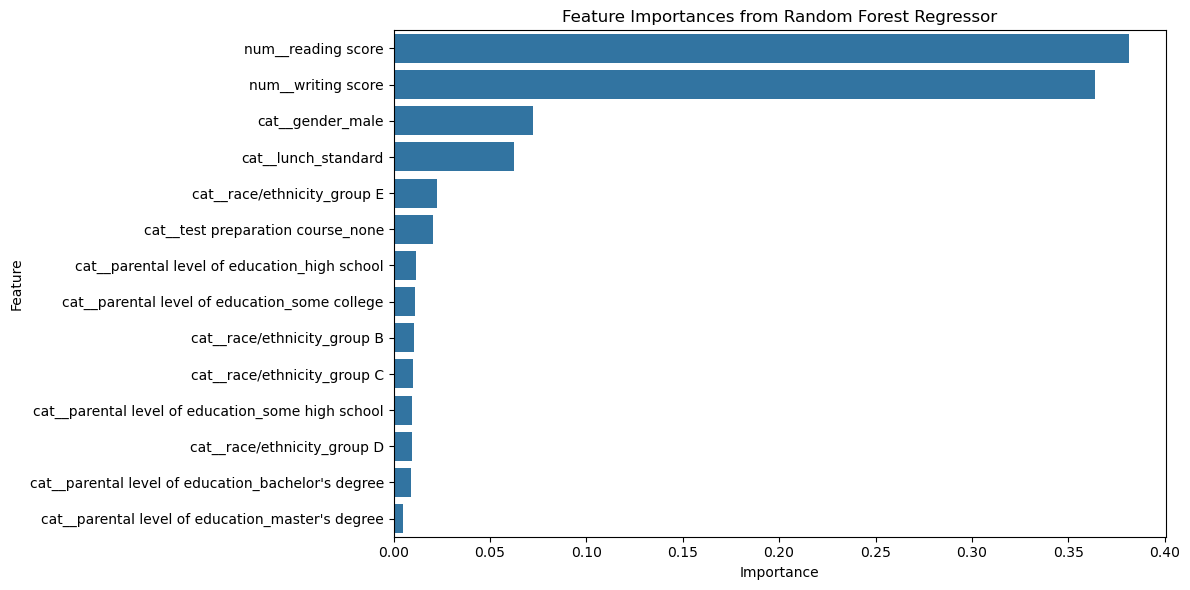

In [20]:

regressor = model.named_steps['regressor']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = regressor.feature_importances_

plt.figure(figsize=(12,6))
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest Regressor')
plt.tight_layout()
plt.show()

